# Noize net
The following notebook contains the code used for both an LSTM and RNN used for investigating the feasibility of music generation using an RNN. 

Note that berevity of code both the RNN and LSTM are implimented in one code base. This does mean that the code is somewhat more complicated and necessitates the use of "LSTMBool" which defines throughout the code if operations will take place for an LSTM or RNN. 

Note to reader: This notebook is a refactor of the main python file noizenet.py


# Imports

First we must import all the necessary dependencies.

Then check if we can run on a GPU.

Additionally we can define the scaler for scaling input data and inverting a scale on output data. 

In [336]:
import matplotlib   
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import librosa as lib
import os
import soundfile as sf #For writing
import matplotlib.pyplot as plt
import gc
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import sklearn as skl
import pandas as pd
import utils
import librosa.display
import noise


# torch.autograd.detect_anomaly(True) #Check for errors and return a stack trace. (Used to debug nan loss)

# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

#Print if we are able to use a GPU
if(train_on_gpu):
    print('Processing on GPU.')
else:
    print('No GPU available.')

scaler = sklearn.preprocessing.StandardScaler()

Processing on GPU.


# Helper functions
Bellow we define some functions that will be used later in this work

## Time to FT
Convert an array of time/amplitude values to frequency domain

In [337]:
def time_to_fft(time_domain):
    # Compute FFT
    fft = np.fft.fft(time_domain)
    # Concatinate real and imaginary values
    new_input = np.concatenate((np.real(fft), np.imag(fft))) #Scheme that takes imaginary into account
    #new_input = np.real(fft) #Only consider real values
    return new_input

## FT to Time
Convert an array of fourier values to the time domain

In [338]:
def fft_to_time(ft_domain):
    # check if the input can be divinded in two and assign as needed
    if ft_domain.shape[0] % 2 == 0:
        num_elems = (int)(ft_domain.shape[0] / 2)
    else:
        ft_domain = ft_domain[0:-1]
        num_elems = (int)(ft_domain.shape[0] / 2)
    #If we took complex into account
    # Get real part 
    real = ft_domain[0:num_elems]
    # Get imaginary part
    imag = ft_domain[num_elems:]
    # Recompose real and Im parts
    composition = real + 1.0j * imag
    # ifft back to time domain
    
    #If we ignore complex values
    #composition = ft_domain
    time = np.fft.ifft(composition)
    return time

## Batching function 
This function is rarely used in this work but some testing was done with batches to check their performance.

In [339]:
def get_batches(arr, batch_size, seq_length):
    #Note this code was adapted fome Udacity course on machine learning. 
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough elements to fill a batch
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

## Perlin noise generator
For some input array convert each value to perlin noise. 

In [340]:
def genPerlin(x):
    tmp = []
    for xx in x:
        tmp.append(noise.pnoise1(xx))

    return tmp

# Defining the model
Then we can define the Model using the pytorch class definition.

The model contains the following layers:
* LSM or RNN layer 
* Dropout Layer
* Fully connected layer for translating oyutput

After defining the layers in the model we can define a forward function used for the formward pass during training and prediction. 
* Given c0 (Or None for RNN), the hidden state and some imput x.
* Pass the hidden state and input through the RNN layer and recieve some output
* Selectively choose values to drop (Note this only happens for hidden layers > 1)
* Pass the result through the fully connected layer to obtain the final result
* Return the prediction and hidden states

Additionally we define a helper funcation to generate the hidden states for an LSTM

In [341]:
class NoizeNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, LSTMBool, dropout_prob):
        super(NoizeNet, self).__init__()

        self.LSTMBool = LSTMBool  
        self.hidden_dim = hidden_dim
        self.num_layers = n_layers
        self.output_size = output_size
        self.input_size = input_size
        self.dropout_prob = dropout_prob


        #TODO: Test RNN vs LSTM
        if LSTMBool:
            self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=dropout_prob,batch_first=True)
            self.hidden = (torch.zeros(1,1,self.hidden_dim).cuda(), torch.zeros(1,1,self.hidden_dim).cuda()) #We need a tuple for a LSTM
        else:
            # define an RNN with specified parameters
            # batch_first means that the first dim of the input and output will be the batch_size
            self.rnn = nn.RNN(input_size, hidden_dim, n_layers, dropout=dropout_prob, batch_first=True)

        self.dropout = nn.Dropout(dropout_prob)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, c0=None):
        batch_size = x.size(0)
        if (train_on_gpu):
            x.cuda()
        else:
            x.cpu()
        

        if self.LSTMBool:
            h_0 = hidden
            c_0 = c0
            #Rename variables as convention
            state = (h_0, c_0)
            # Propagate input through LSTM
            r_out, (hn, cn) = self.lstm(x, state) #lstm with input, hidden, and internal state
            hidden = hn
        else:
            # get RNN outputs
            r_out, hidden = self.rnn(x , hidden)

        r_out = self.dropout(r_out) #Dropout

        # shape output to be (batch_size*seq_length, hidden_dim)
        if (train_on_gpu):
            hidden.cuda()
            
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        if self.LSTMBool:
            return output, (hidden, cn)
        else:
            return output, hidden
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        #THIS CODE IS FROM UDACITY
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM

        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = torch.autograd.Variable(torch.zeros(self.num_layers, 1, self.hidden_dim)).cuda() #hidden state
            c0 = torch.autograd.Variable(torch.zeros(self.num_layers, 1, self.hidden_dim)).cuda() #internal state
        else:
            hidden = torch.autograd.Variable(torch.zeros(self.num_layers, 1, self.hidden_dim)).cuda() #hidden state
            c0 = torch.autograd.Variable(torch.zeros(self.num_layers, 1, self.hidden_dim)).cuda() #internal state

        return hidden, c0

# Training
We can then define the training function. This function takes in the model, n_steps which is a bit of a misnoma as it is used as the number of full "frame" steps that will complete the impute sequence. An array of genreTracks which are translated into file names. Using AUDIO_DIR and file names we can read in the input songs. Step size is used to determine how large of a step to take in the training data. Duration is the duration of the input song to read in. Number of tracks is the number of songs that we will train on. Clip is the value of the griadient clipping. 

In this work we vary the training procedue among trails. However the procedure remains unchanged and is as follows:
* Ensure model is in training mode
* load validation data and perform and needed transformations/scaling
* Initialize hidden layers
* Loop over a number of input tracks
* At each loop iteration
    * Load and transform input training data
    * Define the needed variables
    * Check if input data contains a NaN value
    * For some number of steps that was calculated earlier
        * For some number of epochs 
            * Select some data
            * Ensure data has a shift in input and target
            * Convert to tensors and give the input a batch size dimension of one
            * Move data to GPU if we can
            * Get a prediction frome the LSTM or RNN
            * Detach hidden states from history
            * Zero gradients
            * Calculate loss and add it to the plot array
            * Perform backward step
            * Clip gradients
            * Take an optimizer step to optimize weights
            * Perform validation (I will not walk through this as it is the same procedure in eval mode)
    * Clean memory if the model is large
* Plot losses
* Return the trained model

In [342]:
def train(noizeNet, n_steps, AUDIO_DIR, genreTracks, LSTM ,step_size=1, duration=5, numberOfTracks=1, clip=5, fft_bool=False):
    fileCount = 0 #Used for displaying the file that is currently being trained on
    noizeNet.train() #Set the model to training mode
    lossArr = [] #Array used to plot loss over time
    val_losses = []
    if(train_on_gpu):
        noizeNet.cuda() #Move the model to GPU if available

    val_file = utils.get_audio_path(AUDIO_DIR, genreTracks[-1])
    val_data, sr = lib.load(val_file, mono=True, duration = duration)
    
    
    if fft_bool:
        print("We are training on FFT data")
        val_data = time_to_fft(val_data)
    val_data = scaler.fit_transform(val_data.reshape(-1,1)) #Scale data
    hidden = None
    c0 = None
    hidden, c0 = noizeNet.init_hidden(1)
    #Loop over all the files in our filtered list
    for id in genreTracks: 
        #Stop training after n files
        fileCount+=1
        if(fileCount > numberOfTracks):
            break 

        filename = utils.get_audio_path(AUDIO_DIR, id) #Get the actual path to the file from the id
        
        fileData, sr = lib.load(filename, mono=True, duration = duration)
        fileData = fileData.reshape(-1,1)
        if fft_bool:
            fileData = time_to_fft(fileData)
        fileData = scaler.fit_transform(fileData)

        data = fileData
        batch_size = (int)(duration*sr/n_steps) #Find the size of the window that slides across the input song
        number_of_steps = (int)(duration*sr)-batch_size #Assumes step size of one as a larger step size produced poor results

        if(np.isnan(np.sum(fileData))):
            print("NAN ON FILE:\t", filename)
            break
        
        for batch_i in (range(0,number_of_steps, step_size)):
            for e in range(0,1):
                # for batch_i in (range(0,number_of_steps, step_size)):
                # if LSTM:
                #     (hidden, c0) = noizeNet.init_hidden(batch_size)
                # for x, y in get_batches(fileData, 500, 50):
                
                # defining the training data
                data = fileData[(batch_i): batch_size + batch_i]
                # data = np.resize(data,((batch_size), 1)) 
                # data = data.reshape(batch_size,1)  
                # data = data.reshape(len(data),1)    
                x = data[:-1] #Select all but the last element in the input data
                y = data[1:] #Select all but the first element in the input data. Essentially a forward shift in time

                # convert data into Tensors
                x_tensor = torch.Tensor(x).unsqueeze(0)  # unsqueeze gives a 1, batch_size dimension
                y_tensor = torch.Tensor(y)
                if(train_on_gpu):
                        x_tensor, y_tensor = x_tensor.cuda(), y_tensor.cuda()
                
                if LSTM:
                    prediction, (hidden, c0) = noizeNet(x_tensor, hidden, c0) #LSTM!
                else:
                    # outputs from the rnn
                    prediction, hidden = noizeNet(x_tensor, hidden)
                
                ## Representing Memory ##
                # make a new variable for hidden and detach the hidden state from its history
                # this way, we don't backpropagate through the entire history
                hidden = hidden.data

                if LSTM:
                    c0 = c0.data #LSTM!


                # zero gradients
                optimizer.zero_grad()

                # calculate the loss
                
                loss = criterion(prediction, y_tensor)
                # if(np.isnan(loss)):
                #     break
                lossArr.append(loss.item())
                # perform backprop and update weights
                loss.backward()
                
                torch.nn.utils.clip_grad_value_(noizeNet.parameters(), clip) #Clip gradient
                optimizer.step()


                #Validation step
                if(int((batch_i)) % 1000 == 0):
                    if LSTM:
                        (val_h, val_c) = noizeNet.init_hidden(1)
                    else:
                        val_h = None

                    
                    noizeNet.eval()
                    val_x = val_data[:-1]
                    val_y = val_data[1:]

                    

                    for e in range(0,10):
                        val_x = val_data[:-1]
                        val_y = val_data[1:]
                        val_x, val_y = torch.from_numpy(val_x), torch.from_numpy(val_y)
                        
                        
                        inputs, targets = val_x.reshape(-1,1).unsqueeze(0), val_y.reshape(-1,1)
                        if(train_on_gpu):
                            inputs, targets = inputs.cuda(), targets.cuda()
                        if LSTM:
                            output, (val_h, val_c) = noizeNet(inputs, val_h, val_c)
                        else:
                            output, val_h = noizeNet(inputs, val_h)
                        val_loss  = criterion(output, targets)

                        val_losses.append(val_loss.item())

                        if LSTM:
                            val_h = val_h.data
                            val_c = val_c.data
                        else:
                            val_h = val_h.data


                    print("Training Progress:\t", round((fileCount*e/(number_of_steps*numberOfTracks))*100, 2), "%"  , sep="")
                    print("P:\t", prediction.cpu().data.numpy().flatten()[-5:],"\nY:\t", y[-5:].flatten() ,"\nX:\t" , x[-5:].flatten() ,sep="")
                    print('Training Loss: ', loss.item(), "Validation loss: ", val_loss.item() , "\t num:", batch_i, "\t File:", fileCount)
                    noizeNet.train() # reset to train mode after validation
            
            #Clean unused variables to ensure memory is kept free
            # del prediction
            # del x_tensor
            # del y_tensor
            # del data
            # del x
            # del y
            # gc.collect()
        fig, ax = plt.subplots(nrows=2)
        ax[0].plot(lossArr)
        ax[0].set(title="Training loss", ylabel="Loss", xlabel="Epochs")
        ax[1].plot(val_losses)
        ax[1].set(title="Validation loss", ylabel="Loss", xlabel="Epochs")
        fig.tight_layout()
        plt.show()
    return noizeNet

# Prediction and Music generation

Then we define the prediction function. 

In this work we have two prediction schemes that produce equivalent results. I will explain them independently. 

## Prediction scheme 1 
This prediction sheme functions as follows
* Recieve the model, prediction seed track, duration of seed, prediction duration and LSTM bool
* Read in the seed data and perform any needed scaling/transformation
* Select some range of the seed and obtain a prediction from the model
* Record the last element in the prediction
* Append this predicted value to a music array that will become the generated song
* Shift the data window to exclude an early data point and append the predicted value
* Repeat this procedure until we have predicted enough points for the desired music output. 

In [343]:
def predict(noizeNet, genreTrack ,duration=1, n_steps=30, LSTMBool=False, predictDuration = 30, step_size=1, fft_bool=False):
    print("PREDICTING...")
    noizeNet.eval()
    hidden = None
    
    if LSTMBool:
        (hidden, c0) = noizeNet.init_hidden(1)
        
    filePath = utils.get_audio_path(AUDIO_DIR, genreTrack) #Get the actual path to the file from the id
    y, sr = lib.load(filePath, mono=True, duration = duration)
    if fft_bool:
        y = time_to_fft(y)
    y = scaler.fit_transform(y.reshape(-1,1))

    data = y
    

    # data = np.random.normal(-1,1,y.shape)
    # data = genPerlin(np.linspace(0,1,y.size))
    batch_size = (int)(sr*duration/n_steps)



    number_of_steps = (int)(sr*predictDuration/step_size)

    music = []
    next = data[batch_size-1]

    sf.write('/home/liam/Desktop/University/2021/MAM3040W/thesis/writeup/code/predictionSeed.wav', np.append( data[step_size: batch_size], next), sr,format="WAV")
    print("BATCH SIZE:", batch_size ,sep="\t")
    print("NUMBER OF STEPS:", number_of_steps , sep="\t")
    # data = data[0: batch_size-1]
    hidden = None
    c0 = None
    hidden, c0 = noizeNet.init_hidden(1)
    for batch_i in (range(0, number_of_steps)):
        if(train_on_gpu):
            noizeNet.cuda()
        data = data[batch_i: batch_size-1 + batch_i]
        data = np.append(data,next)
        x = data.reshape(-1,1)

        if(np.isnan(np.sum(data))):
            print("data contains NAN", data)

        x_tensor = torch.Tensor(x).unsqueeze(0)  # unsqueeze gives a 1, batch_size dimension
        if(train_on_gpu):
                x_tensor = x_tensor.cuda()

        if(LSTMBool):
            prediction, (hidden, c0) = noizeNet(x_tensor, hidden, c0)
            c0 = c0.data
        else:
            prediction, hidden = noizeNet(x_tensor, hidden)
        hidden = hidden.data
        
        
        music = np.append(music,(prediction.cpu().data.numpy().flatten())[-1])
        next = prediction.cpu().data.numpy().flatten()[-1]
        
        if(int((batch_i)) % 100 == 0):
            # fig, ax = plt.subplots(nrows=2)
            # ax[0].plot(prediction.cpu().data.numpy())
            # ax[1].plot(scaler.inverse_transform(prediction.cpu().data.numpy()))
            # print(np.average(prediction.cpu().data.numpy()))
            # print(prediction.cpu().data.numpy().flatten()[-1:])
            # print(x)
            # ax[1].plot(fft_to_time(prediction.cpu().detach().numpy()))
            # plt.show()
            print("PROGRESS:\t", round(((batch_i)/number_of_steps)*100, 2), "%"  , sep="")
            print("Prediction dimensions:\t", prediction.cpu().size(), "\t" ,prediction.cpu().data.numpy().flatten().size, "\nMusic dimensions:\t", music.size ,sep="")
       
    print(music)
    music = scaler.inverse_transform(music.reshape(-1,1))
    if fft_bool:
        music = fft_to_time(music).astype('float32')

    sf.write('/home/liam/Desktop/University/2021/MAM3040W/thesis/writeup/code/outputSoundFile.wav', (music), 22050,format="WAV")
    time_steps = np.linspace(0, len(music), len(music))
    plt.plot(time_steps, music,"b.",  markersize=0.1)
    plt.show()
    return music

## Prediction Scheme 2
This scheme is similar to the previous one, however, more efficient as we process the seed element by elements and then pass the hidden states to a new function that will begin predicting new values from the last predicted value from the seed and hidden states. 

In [344]:
def predict2(noizeNet, genreTrack ,duration=1, n_steps=30, LSTMBool=False, predictDuration = 30, step_size=1, fft_bool=False):
    print("PREDICTING...")
    noizeNet.eval()

    if LSTMBool:
        hidden, c0 = noizeNet.init_hidden(1)
    else:
        hidden = None
    filePath = utils.get_audio_path(AUDIO_DIR, genreTrack) #Get the actual path to the file from the id
    y, sr = lib.load(filePath, mono=True, duration = duration)
    y = time_to_fft(y)
    y = scaler.fit_transform(y.reshape(-1,1))
#     y = np.random.normal(-1,1,y.shape)
#     data = genPerlin(np.linspace(0,1,y.size))
    sf.write('/home/liam/Desktop/University/2021/MAM3040W/thesis/writeup/code/Predict2Seed.wav', y, 22050,format="WAV")
    
     
    batch_size = (int)(sr*duration/n_steps)

    number_of_steps = (int)(sr*duration/step_size)
    music = []
    for batch_i in (range(0, number_of_steps)):
        if(train_on_gpu):
            noizeNet.cuda()
        data = y[batch_i]
        data = data.reshape(-1,1)
        x = data


        x_tensor = torch.Tensor(x).unsqueeze(0)  # unsqueeze gives a 1, batch_size dimension
        if(train_on_gpu):
                x_tensor = x_tensor.cuda()

        if(LSTMBool):
            prediction, (hidden, c0) = noizeNet(x_tensor, hidden, c0)
            c0 = c0.data
        else:
            prediction, hidden = noizeNet(x_tensor, hidden)
        hidden = hidden.data
        
        music = np.append(music,(prediction.cpu().data.numpy().flatten())[-step_size:])
        if(int((batch_i)) % 1000 == 0):
            print("PROGRESS:\t", round(((batch_i)/number_of_steps)*100, 2), "%"  , sep="")
            print("Prediction dimensions:\t", prediction.cpu().size(), "\t" ,prediction.cpu().data.numpy().flatten().size, "\nMusic dimensions:\t", music.size ,sep="")
       
    sf.write('/home/liam/Desktop/University/2021/MAM3040W/thesis/writeup/code/outputSoundFilePredict2.wav', (music), 22050,format="WAV")
    time_steps = np.linspace(0, len(music), len(music))
    plt.plot(time_steps, music,"b.",  markersize=1)
    plt.show()
    if LSTMBool:
        return music, (hidden, c0)
    else: 
        return music, hidden

In [345]:
def predict3(noizeNet, seeded ,duration=1, n_steps=30, LSTMBool=False, predictDuration = 30, step_size=1, hidden = None, c0 = None, fft_bool=False):
    print("PREDICTING...")
    noizeNet.eval()
    number_of_steps = (int)(22050*predictDuration/step_size)
    music = []
    x = [0]
    for batch_i in (range(0, number_of_steps)):
        if(train_on_gpu):
            noizeNet.cuda()
        seeded = np.array([seeded]).reshape(-1,1)
        data = seeded
#         if x[0] - seeded[0] < 0.0001:
#             data = seeded + np.random.normal(-1,1)
        data = data.reshape(-1,1)
        x = data
        
        x_tensor = torch.Tensor(x).unsqueeze(0)  # unsqueeze gives a 1, batch_size dimension

        if(train_on_gpu):
                x_tensor = x_tensor.cuda()

        if (LSTMBool):
            prediction, (hidden, c0) = noizeNet(x_tensor, hidden, c0)
            c0 = c0.data
        else:
            prediction, hidden = noizeNet(x_tensor, hidden)
        hidden = hidden.data
        
        seeded = prediction.cpu().data.numpy()[-1:step_size:]
        music = np.append(music,(prediction.cpu().data.numpy().flatten())[-step_size:])
        if(int((batch_i)) % 10000 == 0):
            print("PROGRESS:\t", round(((batch_i)/number_of_steps)*100, 2), "%"  , sep="")
            print("Prediction dimensions:\t", prediction.cpu().size(), "\t" ,prediction.cpu().data.numpy().flatten().size, "\nMusic dimensions:\t", music.size ,sep="")
       
    
    music = scaler.inverse_transform(music.reshape(-1,1))
    if fft_bool:
        music = fft_to_time(music).astype('float32')
    
    print(music)
    sf.write('/home/liam/Desktop/University/2021/MAM3040W/thesis/writeup/code/outputSoundFilePrediction3.wav', (music), 22050,format="WAV")
    time_steps = np.linspace(0, len(music), len(music))
    plt.plot(time_steps, music,"b.",  markersize=1)
    plt.show()
    return music

## Saving function
A helper function used for naming a model by it's hyer parameters.

In [346]:
def generateModelName(n_steps = 30, print_every = 5, step_size =  1, duration = 5, numberOfTracks = 1, clip = 5, LSTMBool=False, hidden_dim=50,n_layers=1, fft_bool=False):
    return "n_steps="+ str(n_steps) + "__" +"print_every="+ str(print_every) + "__" +"step_size="+ str(step_size) + "__" +"duration="+ str(duration) + "__" +  \
    "numberOfTracks="+ str(numberOfTracks) + "__" +  "clip="+ str(clip) + "__" +  "LSTMBool="+ str(LSTMBool) + "hidden_dim="+ str(hidden_dim) + "__" +"n_layers="+ str(n_layers) +"__"+ "lr=" + str(lr) + "__fft_bool" + str(fft_bool)+ ".pt"


# Hyper parameters
Before we start training we must declair the hyperparameters and instantiate the model.

I believve all of these variables should be self explanatory. Note this is also where we choose if the miodel will be an LSTM or RNN.

In [347]:
# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=50
n_layers=1
LSTMBool = True
dropout_prob = 0.5

# instantiate an RNN/LSTM
noizeNet = NoizeNet(input_size, output_size, hidden_dim, n_layers, LSTMBool, dropout_prob)
print(noizeNet)

# The two criterions used in this work
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
lr=0.0001

# The various optimizers used in this work

# optimizer = torch.optim.Adam(noizeNet.parameters(), lr=lr)
# optimizer = torch.optim.SGD(noizeNet.parameters(),lr=lr)
optimizer = torch.optim.Adadelta(noizeNet.parameters())

NoizeNet(
  (lstm): LSTM(1, 50, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Music filtering by genre

Here we just filter all the data in FMA for some chosen genre. 

In [348]:
#Get metadata for fma dataset
AUDIO_DIR = "data/fma_small/"

tracks = utils.load('data/fma_metadata/tracks.csv')

small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
# genre2 = tracks['track', 'genre_top'] == 'Hip-Hop' #We can set multilpe genres bellow as (genre1 | genre2)
genreTracks = list(tracks.loc[small & (genre1),('track', 'genre_top')].index)

# Training variables

Initialise the variables needed for training the network

In [349]:
#Set if we want to train new model or load and predict with saved model
TRAIN = True

fft_bool = True
n_steps = 30 #The number of full frame steps to be taken to complete training
print_every = 5 
step_size =  1 #The step size taken by each training frame 
duration = 1 #The duration of the training segment
predictDuration = 1 #The duration of the predicted song is seconds
numberOfTracks = 10 #The number of tracks to be trained on
clip = 1 #Gradient clipping
seedDuration = 1

# Begin Training or load model and predict
Then we can call our training and prediction functions as needed. 

Training...


/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.0%
P:	[-0.04148765 -0.04190989  0.00770663 -0.11899094 -0.00943834]
Y:	[2.3680072 2.6157584 2.809463  2.917797  2.970978 ]
X:	[2.1291304 2.3680072 2.6157584 2.809463  2.917797 ]
Training Loss:  0.40615519881248474 Validation loss:  0.7488835453987122 	 num: 0 	 File: 1
Training Progress:	0.0%
P:	[1.0403188 1.2608074 1.3871007 1.4453369 1.5416565]
Y:	[1.063805  1.2334257 1.3820069 1.4955089 1.5618503]
X:	[0.8836078 1.063805  1.2334257 1.3820069 1.4955089]
Training Loss:  0.12595102190971375 Validation loss:  0.16760891675949097 	 num: 1000 	 File: 1
Training Progress:	0.0%
P:	[-2.1105092 -3.007792  -3.003562  -2.0767844 -2.8789902]
Y:	[-2.4671204 -2.429333  -2.3626761 -2.2830684 -2.195706 ]
X:	[-2.4906256 -2.4671204 -2.429333  -2.3626761 -2.2830684]
Training Loss:  0.10663503408432007 Validation loss:  0.14835821092128754 	 num: 2000 	 File: 1
Training Progress:	0.0%
P:	[0.06633473 0.16127577 0.34056604 0.5747158  0.67932755]
Y:	[0.10892892 0.2685368  0.4308728  0.5

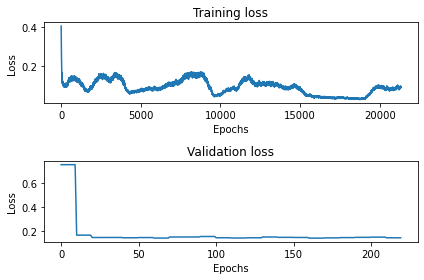

/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.01%
P:	[ 0.00320791 -0.02345066 -0.00606257  0.02170232  0.01476733]
Y:	[0.00849861 0.00780146 0.00859795 0.01016653 0.01118269]
X:	[0.00710151 0.00849861 0.00780146 0.00859795 0.01016653]
Training Loss:  0.01043497771024704 Validation loss:  0.14823848009109497 	 num: 0 	 File: 2
Training Progress:	0.01%
P:	[0.77986485 2.090405   1.6041869  1.6558883  1.9352499 ]
Y:	[1.6482593 2.5099978 1.8570096 1.4422909 2.3843555]
X:	[1.0396476 1.6482593 2.5099978 1.8570096 1.4422909]
Training Loss:  0.2081509530544281 Validation loss:  0.27768757939338684 	 num: 1000 	 File: 2
Training Progress:	0.01%
P:	[-1.2415061 -1.2487223 -2.8194284 -1.4852403 -1.5880543]
Y:	[-0.855364  -1.6490508 -2.510213  -1.8053945 -1.7115581]
X:	[-1.8935641 -0.855364  -1.6490508 -2.510213  -1.8053945]
Training Loss:  0.2965712249279022 Validation loss:  0.2584458291530609 	 num: 2000 	 File: 2
Training Progress:	0.01%
P:	[2.7134137 1.1362339 2.8999243 3.003479  1.9159334]
Y:	[2.7697644 1.682964  2.07

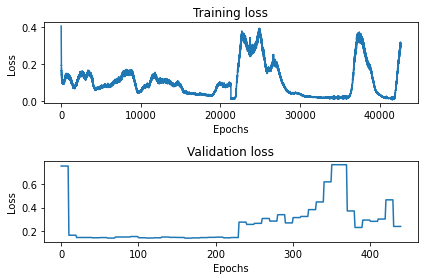

/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.01%
P:	[-1.1344337  -1.0977148  -1.654862   -1.0889652  -0.74854285]
Y:	[-1.2093945  -0.9979848  -0.8359717  -0.75957656 -0.8624972 ]
X:	[-1.3914678  -1.2093945  -0.9979848  -0.8359717  -0.75957656]
Training Loss:  0.29864639043807983 Validation loss:  0.2222471684217453 	 num: 0 	 File: 3
Training Progress:	0.01%
P:	[-1.1133672 -1.3619373 -2.020464  -1.8994733 -1.538145 ]
Y:	[-1.2997463 -1.5273334 -1.7703266 -1.9344914 -1.7910452]
X:	[-1.0056413 -1.2997463 -1.5273334 -1.7703266 -1.9344914]
Training Loss:  0.1375826597213745 Validation loss:  0.14208568632602692 	 num: 1000 	 File: 3
Training Progress:	0.01%
P:	[ 0.126313   -0.12542951 -0.03556743  0.43005055  0.7291495 ]
Y:	[ 0.10806998 -0.05230034  0.07709642  0.42092842  0.67164075]
X:	[ 0.2706894   0.10806998 -0.05230034  0.07709642  0.42092842]
Training Loss:  0.09292186796665192 Validation loss:  0.13488073647022247 	 num: 2000 	 File: 3
Training Progress:	0.01%
P:	[-0.17818534 -0.34463525 -0.5871594  -0.4453

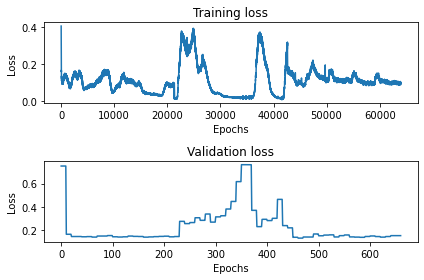

/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.02%
P:	[-0.2841624  -0.29557696  0.06521638  0.14581992  0.15935038]
Y:	[-0.12873518 -0.13683079  0.00200315  0.08777073 -0.04344019]
X:	[ 0.212913   -0.12873518 -0.13683079  0.00200315  0.08777073]
Training Loss:  0.1500401794910431 Validation loss:  0.1426793336868286 	 num: 0 	 File: 4
Training Progress:	0.02%
P:	[ 0.8709607   0.6521081   0.35748413 -0.04312228 -0.23992182]
Y:	[ 0.8773219   0.65830845  0.28198195 -0.06239559 -0.3690481 ]
X:	[ 0.8247909   0.8773219   0.65830845  0.28198195 -0.06239559]
Training Loss:  0.09608931094408035 Validation loss:  0.17298553884029388 	 num: 1000 	 File: 4
Training Progress:	0.02%
P:	[-0.3975411  -0.44000888 -0.99538314 -0.62445664 -0.8002925 ]
Y:	[-0.3586295  -0.5276141  -0.78309566 -0.85265124 -0.6830731 ]
X:	[-0.3019547  -0.3586295  -0.5276141  -0.78309566 -0.85265124]
Training Loss:  0.1039847806096077 Validation loss:  0.1953946053981781 	 num: 2000 	 File: 4
Training Progress:	0.02%
P:	[ 0.18998602 -0.13376898 -0.510

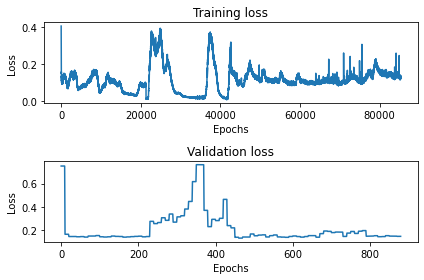

/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.02%
P:	[0.8928042 0.9791834 1.007657  1.1442862 1.4097154]
Y:	[0.92236674 1.071507   1.1970711  1.2990974  1.292677  ]
X:	[0.7237965  0.92236674 1.071507   1.1970711  1.2990974 ]
Training Loss:  0.21710458397865295 Validation loss:  0.1477634161710739 	 num: 0 	 File: 5
Training Progress:	0.02%
P:	[2.0340073  3.1787271  2.072752   1.4368404  0.90009654]
Y:	[3.019339  2.5507178 1.9485664 1.365553  0.864587 ]
X:	[3.2619314 3.019339  2.5507178 1.9485664 1.365553 ]
Training Loss:  0.20335978269577026 Validation loss:  0.17326320707798004 	 num: 1000 	 File: 5
Training Progress:	0.02%
P:	[2.3840244 2.8536127 2.1352494 2.6498263 1.9351484]
Y:	[2.7758815 2.6075873 2.5067878 2.3731196 2.1332004]
X:	[2.9859276 2.7758815 2.6075873 2.5067878 2.3731196]
Training Loss:  0.1749926060438156 Validation loss:  0.18700754642486572 	 num: 2000 	 File: 5
Training Progress:	0.02%
P:	[3.7590754 4.7092214 5.0349417 4.3652744 3.155963 ]
Y:	[4.3927245 4.4087825 4.2572637 3.8640034 3.379511

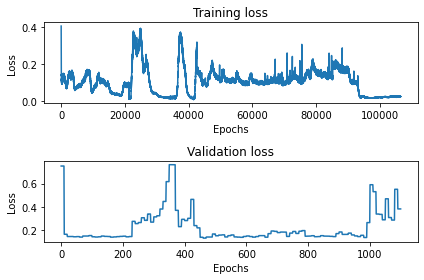

/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.03%
P:	[ 0.5338654   0.2233481   0.2276668   0.2739029  -0.07997029]
Y:	[ 0.76676095  0.4642044   0.45060793  0.19573133 -0.45871073]
X:	[1.3235732  0.76676095 0.4642044  0.45060793 0.19573133]
Training Loss:  0.5194140672683716 Validation loss:  0.37511610984802246 	 num: 0 	 File: 6
Training Progress:	0.03%
P:	[0.00536419 0.14179008 0.20343171 0.74537224 1.2436461 ]
Y:	[-0.04118323  0.17880492  0.32865202  0.7074005   1.1257282 ]
X:	[-0.5527038  -0.04118323  0.17880492  0.32865202  0.7074005 ]
Training Loss:  0.1067701131105423 Validation loss:  0.1625053584575653 	 num: 1000 	 File: 6
Training Progress:	0.03%
P:	[ 0.25343397 -0.04999924 -0.16075468 -0.5271387  -0.79511017]
Y:	[ 0.27026924 -0.06175174 -0.30433893 -0.5521076  -0.8334644 ]
X:	[ 0.54479     0.27026924 -0.06175174 -0.30433893 -0.5521076 ]
Training Loss:  0.1171128898859024 Validation loss:  0.1688666045665741 	 num: 2000 	 File: 6
Training Progress:	0.03%
P:	[0.19224338 0.47566962 0.5020737  0.392606

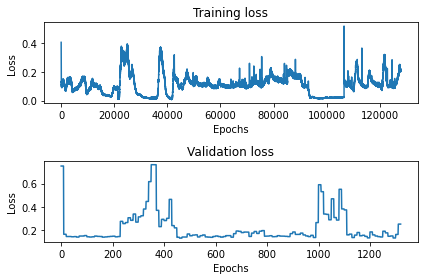

/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.03%
P:	[0.10348441 0.36464736 0.4403441  0.63318264 0.6713872 ]
Y:	[0.0702903  0.2448321  0.3516212  0.42069772 0.5968527 ]
X:	[-0.10409869  0.0702903   0.2448321   0.3516212   0.42069772]
Training Loss:  0.2655488848686218 Validation loss:  0.22079016268253326 	 num: 0 	 File: 7
Training Progress:	0.03%
P:	[0.04921811 0.26274434 0.2532542  0.37863237 0.8190359 ]
Y:	[0.10373238 0.20870143 0.2973348  0.47407228 0.67491055]
X:	[-0.02662059  0.10373238  0.20870143  0.2973348   0.47407228]
Training Loss:  0.08728940784931183 Validation loss:  0.1306028515100479 	 num: 1000 	 File: 7
Training Progress:	0.03%
P:	[-0.0330222   0.1493097   0.21729706  0.21155125  0.1408192 ]
Y:	[-0.00400395  0.13631216  0.1935402   0.1917457   0.15211266]
X:	[-0.17150825 -0.00400395  0.13631216  0.1935402   0.1917457 ]
Training Loss:  0.0683794841170311 Validation loss:  0.128154918551445 	 num: 2000 	 File: 7
Training Progress:	0.03%
P:	[0.30379128 0.29922614 0.42800555 0.51947826 0.55703

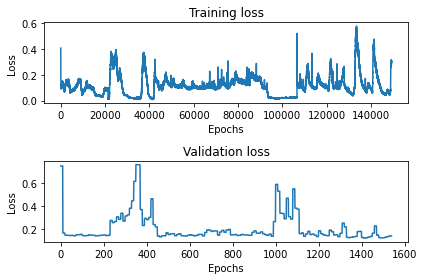

/home/liam/anaconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training Progress:	0.03%
P:	[-0.04363899 -0.0398261  -0.03705641 -0.02885343 -0.01470967]
Y:	[-0.02116982 -0.02180299 -0.02337553 -0.02376205 -0.02403418]
X:	[-0.02160854 -0.02116982 -0.02180299 -0.02337553 -0.02376205]
Training Loss:  0.014756552875041962 Validation loss:  0.14393533766269684 	 num: 0 	 File: 8
Training Progress:	0.03%
P:	[-0.9148985   0.23773175  0.4905713  -0.53598017 -1.2490377 ]
Y:	[-1.0314972   0.3016112   0.07375064 -1.7352449  -1.7814143 ]
X:	[-1.6151879  -1.0314972   0.3016112   0.07375064 -1.7352449 ]
Training Loss:  0.2660778760910034 Validation loss:  0.3898542821407318 	 num: 1000 	 File: 8


In [ ]:
if TRAIN:
    print("Training...")
    trained_rnn = train(noizeNet, n_steps,AUDIO_DIR, genreTracks, LSTMBool ,step_size=step_size, duration = duration, numberOfTracks=numberOfTracks, clip=clip)
    torch.save(trained_rnn.state_dict(), "/home/liam/Desktop/University/2021/MAM3040W/thesis/writeup/" + generateModelName(n_steps, print_every, step_size, duration, numberOfTracks, clip, LSTMBool, hidden_dim,n_layers, fft_bool))
    duration = seedDuration
    # predict(trained_rnn, genreTracks[-1] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration, step_size=step_size)
    if LSTMBool:
        predicted, (hidden, c0) = predict2(trained_rnn, genreTracks[-2] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration, fft_bool=fft_bool)
        predict3(noizeNet, predicted[-1] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration,  hidden=hidden, c0 =c0, fft_bool=fft_bool)
    else: 
        predicted, hidden = predict2(trained_rnn, genreTracks[-2] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration, fft_bool=fft_bool)
        predict3(noizeNet, predicted[-1] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration,  hidden=hidden, fft_bool=fft_bool)
    

    

else:
    # instantiate an RNN
    noizeNet = NoizeNet(input_size, output_size, hidden_dim, n_layers, LSTMBool, dropout_prob)
    noizeNet.load_state_dict(torch.load("/home/liam/Desktop/University/2021/MAM3040W/thesis/writeup/code/good model/n_steps=1__print_every=5__step_size=1__duration=10__numberOfTracks=100__clip=5__LSTMBool=Truehidden_dim=200__n_layers=1__lr=0.0001.pt"))
    duration = seedDuration
    if LSTMBool:
        predicted, (hidden, c0) = predict2(noizeNet, genreTracks[-2] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration, fft_bool=fft_bool)
        predict3(noizeNet, predicted[-1] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration,  hidden=hidden, c0 =c0)
    else: 
        predicted, hidden = predict2(noizeNet, genreTracks[-2] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration, fft_bool=fft_bool)
        predict3(noizeNet, predicted[-1] ,duration=duration, n_steps=n_steps, LSTMBool=LSTMBool, predictDuration = predictDuration,  hidden=hidden, fft_bool=fft_bool)